In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import sys
sys.path.append('/home/diego/Trabajo/Proyectos/Pynterpred_devel/')
import pynterpred as pnt
import numpy as np

In [3]:
receptor = pnt.Receptor('../testsystems/Barnase-Barstar/pdbs/Barnase.pdb','amber14-all.xml',pH=7.0)
ligand   = pnt.Ligand('../testsystems/Barnase-Barstar/pdbs/Barstar.pdb','amber14-all.xml',pH=7.0)

In [4]:
context  = pnt.MMContext(receptor,ligand)

In [5]:
region   = pnt.Region(receptor, ligand, delta_x=1.0, nside=2)

In [6]:
docking  = pnt.Docker(context,region)

In [7]:
docking.evaluation()

100%|██████████| 48/48 [00:27<00:00,  1.74it/s]


In [8]:
docking.region.net.number_of_nodes()

9360

In [9]:
#aux_array=np.array(docking.potential_energies)
#np.save('pes_0.4_5.npy', aux_array)
#docking.potential_energies=list(np.load('pes_0.4_5.npy'))

In [10]:
import matplotlib.pyplot as plt
from simtk import unit
context.center_ligand(center=[100000.0,0.0,0.0]*unit.nanometer)
energy_inf=context.get_potential_energy()._value

In [11]:
energy_min=np.array(docking.potential_energies).min()

In [12]:
print(energy_min,energy_inf)

5841.61767578125 7929.89208984375


In [13]:
mask=np.array(docking.potential_energies)<energy_inf

In [14]:
np.sum(mask)

6266

In [15]:
num_divs=5000
delta_pe=(energy_inf-energy_min)/num_divs
num_nodes_below_threshold=[]
threshold_pes=[]

for ii in range(num_divs):
    energy_blade=energy_min+(ii+1)*delta_pe
    threshold_pes.append(energy_blade)
    num_nodes_below_threshold.append(np.sum(np.array(docking.potential_energies)<energy_blade))    

<IPython.core.display.Javascript object>


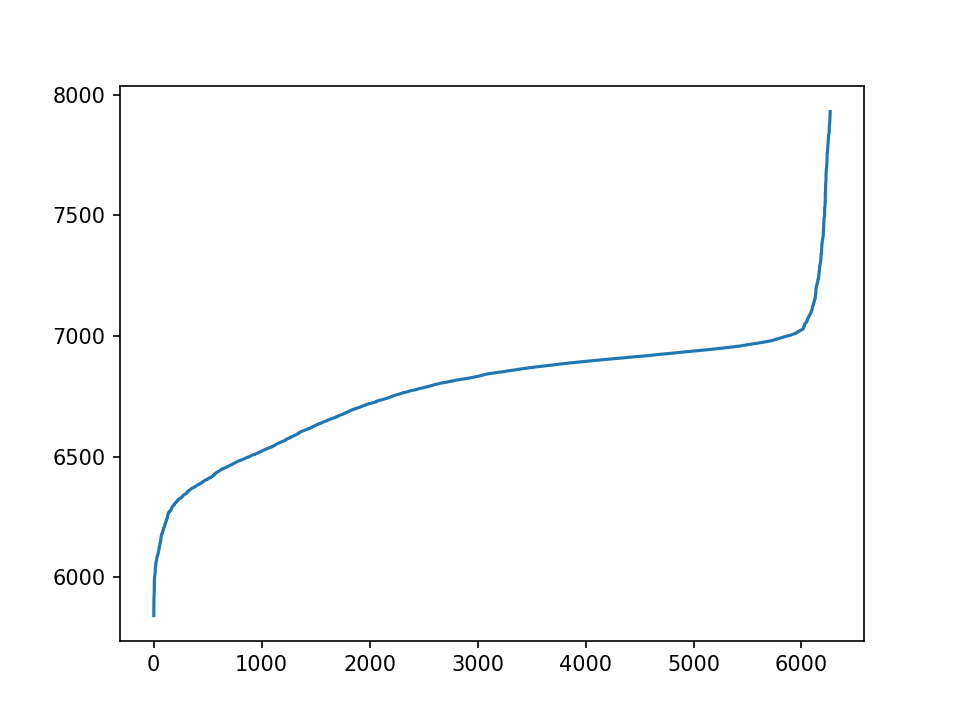

In [16]:
plt.figure()
plt.plot(num_nodes_below_threshold,threshold_pes)

In [17]:
import networkx as nx
import tqdm

tmp_graph=docking.region.net.copy()

num_divs=400
delta_pe=(energy_inf-energy_min)/num_divs
num_components_threshold=[]
threshold_pes=[]

for ii in tqdm.tqdm(range(num_divs)):
    energy_blade=energy_inf-ii*delta_pe
    threshold_pes.append(energy_blade)
    tmp_pes=nx.get_node_attributes(tmp_graph,'Potential_Energy')
    nodes_out=[node_id for node_id, pe in tmp_pes.items() if pe>energy_blade]
    tmp_graph.remove_nodes_from(nodes_out)
    num_components_threshold.append(nx.number_connected_components(tmp_graph))    

100%|██████████| 400/400 [00:23<00:00, 17.34it/s]


<IPython.core.display.Javascript object>


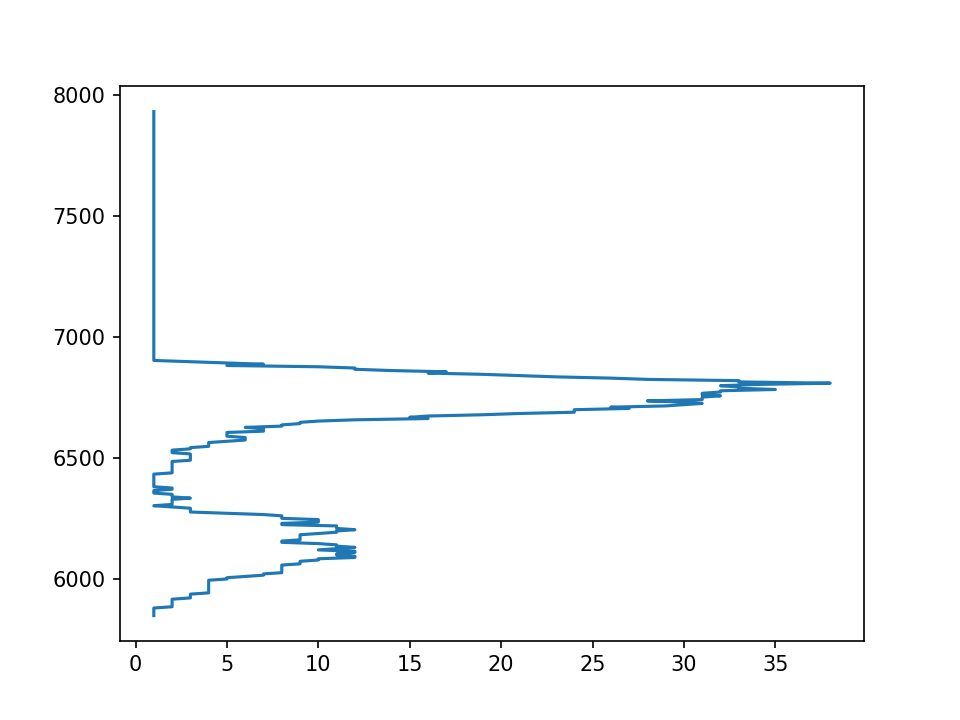

In [18]:
plt.figure()
plt.plot(num_components_threshold,threshold_pes)

In [23]:
energy_blade=6200.0
tmp_pes=nx.get_node_attributes(docking.region.net,'Potential_Energy')
nodes_in=[node_id for node_id, pe in tmp_pes.items() if pe<energy_blade]
net=region.net.subgraph(nodes_in)

<IPython.core.display.Javascript object>


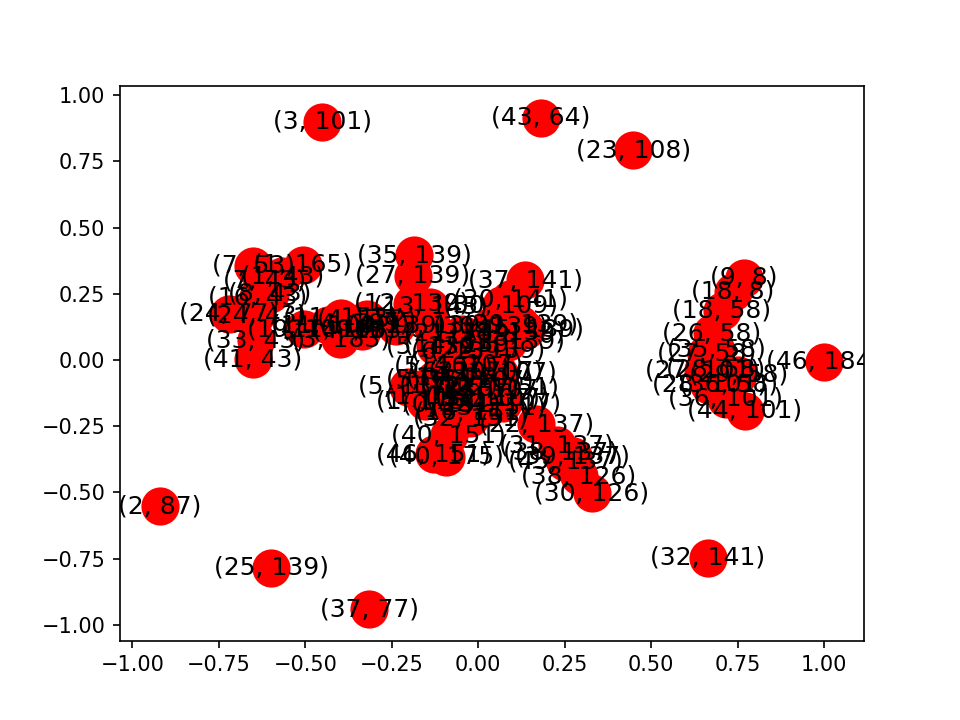

In [24]:
plt.figure()
nx.draw_networkx(net)